In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

import h5py
import logging
from os import path
from pandas import HDFStore
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import shutil
import tempfile
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from sklearn.model_selection import train_test_split



%matplotlib inline

In [ ]:
#!pip install -q git+https://github.com/tensorflow/docs

In [7]:
logdir = pathlib.Path("./fmri")/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [8]:
logdir

PosixPath('fmri/tensorboard_logs')

In [11]:
#Load data from hdf5 file
seed=2020

# origin h5 file location, load and shuffle timeseries
h5_file = '/results/00-EXTRACCION-CEREBELO/elekin_fmri_ts_pandas.hdf5'
tr_key = 'cbl/dataset'#transformed dataset (id,time series matrix 158x28, label)
dataset = pd.read_hdf(h5_file, tr_key)

num_samples = dataset.shape[0]
features = np.stack(dataset['features'].values)
labels = dataset['label'].values.astype('int8')

features.shape, labels.shape

((94, 158, 28), (94,))

In [14]:
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.33)

In [15]:
#Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=20)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=0.0001,
  patience=5)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy'])
        model.summary()
        history = model.fit(X_train, y_train, batch_size=None, use_multiprocessing=True, 
                            validation_data=(X_test,y_test), epochs=max_epochs, callbacks=get_callbacks(name),
                            verbose=0)
        return history

## CNN

Many models train better if you gradually reduce the learning rate during training. 
Use optimizers.schedules to reduce the learning rate over time:

In [23]:
STEPS_PER_EPOCH = 1
FEATURES = 158
CHANNELS = 28

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [24]:
tf.random.set_seed(seed) # establecemos la semilla para tensorflow
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                       activation=tf.nn.relu,
                      input_shape=[FEATURES, CHANNELS]),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                           activation=tf.nn.relu),
#    tf.keras.layers.LSTM(128, activation=tf.nn.relu),
     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [18]:
size_histories = {}

In [25]:
size_histories['cnn/conv1d'] = compile_and_fit(cnn, "cnn/conv1d", optimizer=None, max_epochs=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 154, 16)           2256      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 77, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 73, 16)            1296      
_________________________________________________________________
flatten (Flatten)            (None, 1168)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               149632    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

(0.0, 3.05)

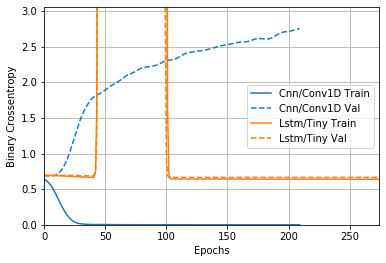

In [38]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter_loss.plot(size_histories)
plt.ylim([0., 3.05])

(0.3, 1.02)

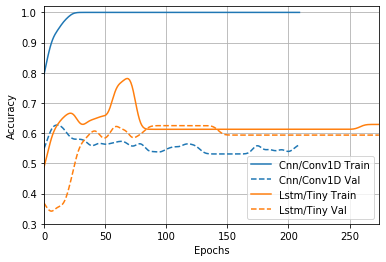

In [39]:
# plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(size_histories)
plt.ylim([0.3, 1.02])